In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import chart_studio
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# plotly api key
plotly_api_key = 'Dns1gp04h4QpiskQPFT3'
chart_studio.tools.set_credentials_file(username='thamsuppp', api_key = plotly_api_key)

/home/isaac/.cache/pypoetry/virtualenvs/econdl-6MXPf6IA-py3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/isaac/.cache/pypoetry/virtualenvs/econdl-6MXPf6IA-py3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [19]:
import skopt.plots
import skopt

In [35]:
# sk_opt evaluation
skopt_results = skopt.load('results/7sep_bayesian_test2/opt_results.pkl')

In [36]:
skopt_results['x']

[0.0, 73, 2, 25, 169, 0.0, 0.004854307603918471, 'nn.ReLU()']

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

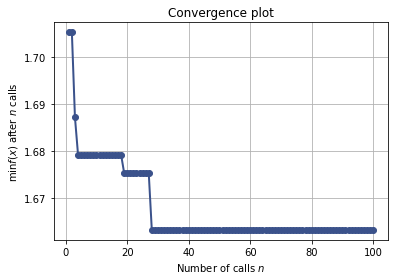

In [30]:
# Plots the best to-date result at each iteration
skopt.plots.plot_convergence(skopt_results)

array([[<AxesSubplot:xlabel='dropout_rate', ylabel='Number of samples'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='nn_width'>,
        <AxesSubplot:xlabel='nn_width', ylabel='Number of samples'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='nn_depth'>, <AxesSubplot:>,
        <AxesSubplot:xlabel='nn_depth', ylabel='Number of samples'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='tvpl'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='tvpl', ylabel='Number of samples'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='constant_tvpl'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='constant_tvpl'

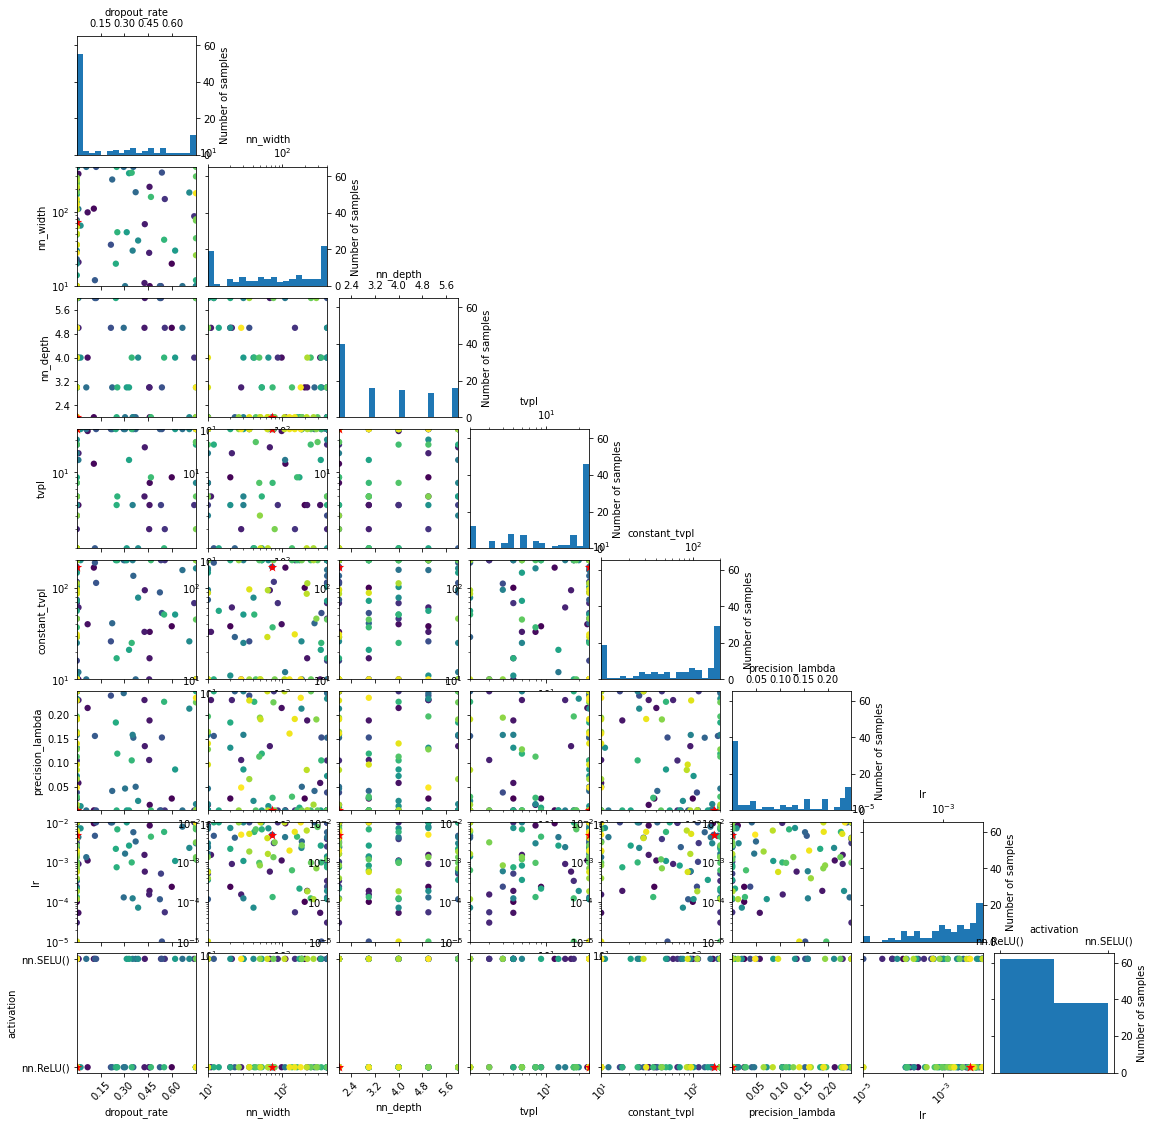

In [31]:
skopt.plots.plot_evaluations(skopt_results)

array([[<AxesSubplot:xlabel='dropout_rate', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='nn_width'>,
        <AxesSubplot:xlabel='nn_width', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='nn_depth'>, <AxesSubplot:>,
        <AxesSubplot:xlabel='nn_depth', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='tvpl'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='tvpl', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='constant_tvpl'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='constant_t

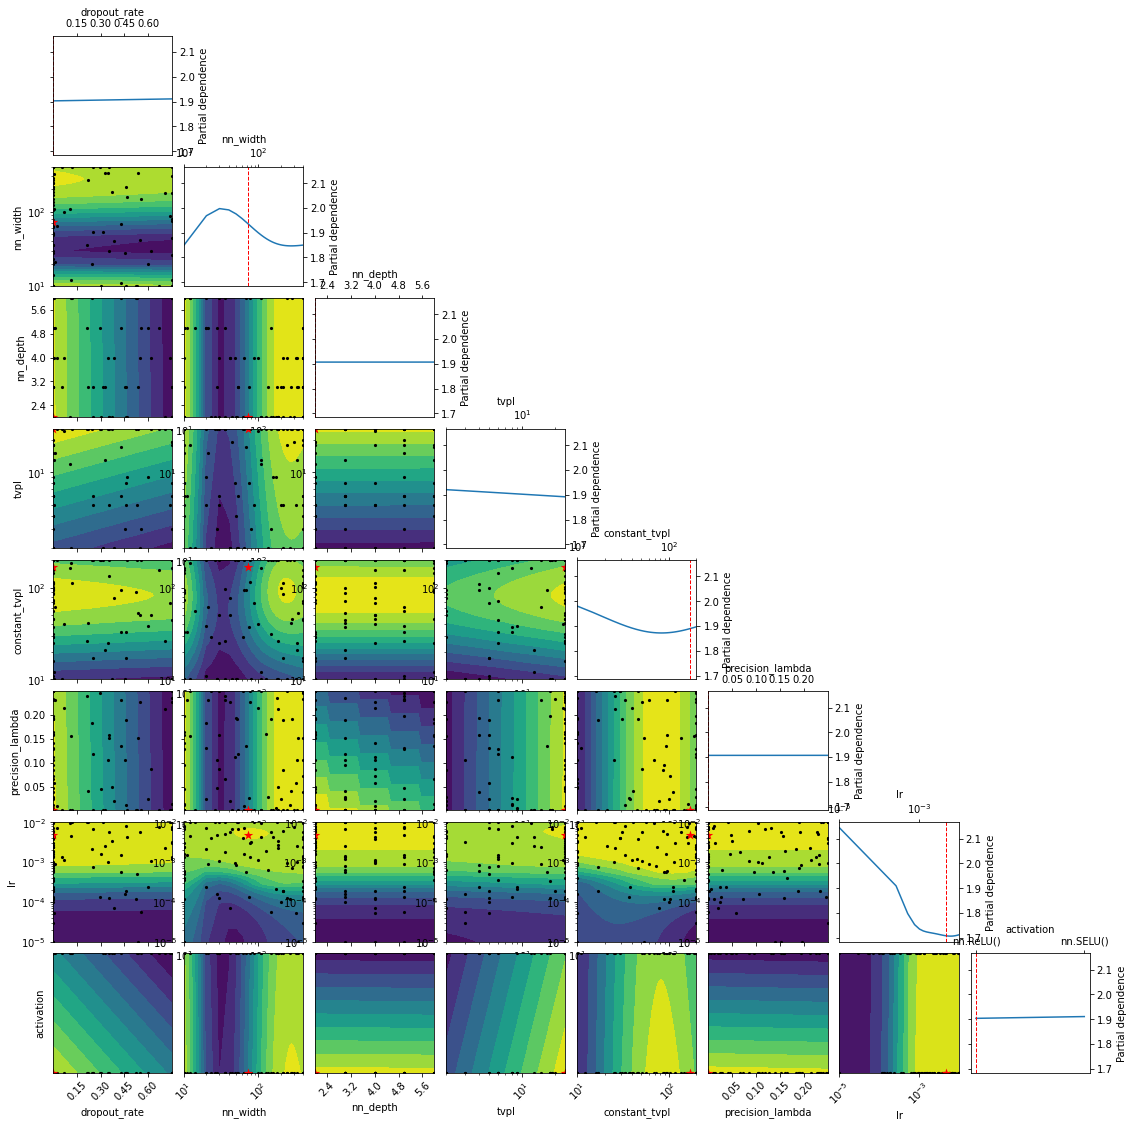

In [32]:
skopt.plots.plot_objective(skopt_results)

In [2]:
# Load npz file
irf = np.load('IRF_conditional.npz')['IRFS'] # (n_obs x n_bootstraps x n_var x n_var x max_h)
irf_median = np.nanmedian(irf, axis = 1) # (n_obs x n_var x n_var x max_h)

In [ ]:
irf

In [3]:
irf_one = irf_median[:, 0, 0, :] # (n_obs x max_h)
irf_unstacked = pd.DataFrame(irf_one).unstack().reset_index()
irf_unstacked.columns = ['horizon', 'time', 'value']

n_var = irf_median.shape[1]

In [8]:
px.colors.qualitative.Plotly[0]

'#636EFA'

In [47]:
# Plotly graph for conditional IRFs


fig = make_subplots(rows = 3, cols = 3,
                    subplot_titles = [f'IRF {k} -> {kk}' for k in range(n_var) for kk in range(n_var)],
                    specs = [[{'is_3d': True} for e in range(n_var)] for e in range(n_var)],
                    shared_xaxes = False,
                    shared_yaxes = False,
                    horizontal_spacing = 0,
                    vertical_spacing = 0.05
)

for k in range(n_var):
  for kk in range(n_var):
    
    fig.add_trace(go.Surface(name = 'Exp 1', z = irf_median[:, kk, k, :], showscale = False, showlegend = True, 
          colorscale = [[0, px.colors.qualitative.Plotly[0]], [1, px.colors.qualitative.Plotly[0]]],
          cmin = 0, cmax = 0, opacity = 0.7),
          row = k+1, col = kk+1)

    fig.add_trace(go.Surface(name = 'Exp 2', z = irf_median[:, kk, k, :] * 2 + 0.01, showscale = False, showlegend = True, 
          colorscale = [[0, px.colors.qualitative.Plotly[1]], [1, px.colors.qualitative.Plotly[1]]],
          cmin = 0, cmax = 0, opacity = 0.7),
          row = k+1, col = kk+1)

fig.update_scenes(xaxis_title = 'Horizon',
                  yaxis_title = 'Time', 
                  zaxis_title = 'Value',
                  camera = {
                  'up': {'x': 0, 'y': 0, 'z': 1},
                  'center': {'x': 0, 'y': 0, 'z': 0},
                  'eye': {'x': 1.25, 'y': -1.5, 'z': 0.75}
                  })


fig.update_layout(title='Conditional IRFs', autosize=False,
                  width = 1000, height=1000,
                  margin=dict(l=25, r=25, b=65, t=90))

fig.show()

fig.write_html('interactive_irf.html')

Text(0.5, 0.92, 'Conditional IRFs for Var 1 -> Var 0')

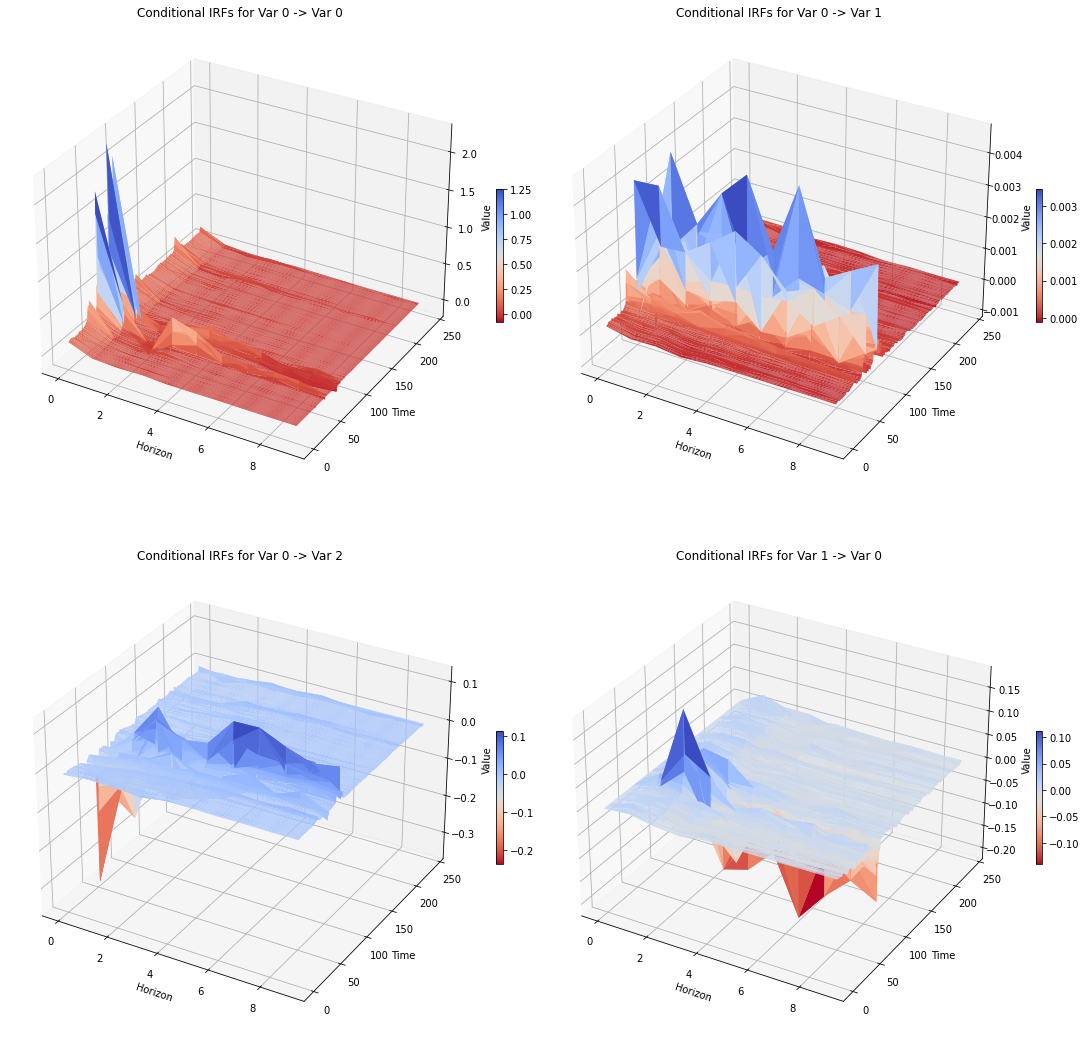

In [60]:
# Surface plots (non-interactiv)

fig = plt.figure(figsize = (5 * n_var, 5 * n_var), constrained_layout = True)

surf = ax.plot_trisurf(irf_unstacked['horizon'], irf_unstacked['time'], irf_unstacked['value'], cmap = plt.cm.coolwarm_r, linewidth = 0.2)
fig.colorbar(surf, shrink = 0.25, aspect = 20)
ax.set_xlabel('Horizon')
ax.set_ylabel('Time')
ax.set_zlabel('Value')
ax.view_init(30, -60)
ax.set_title(f'Conditional IRFs for Var {k} -> Var {kk}')

k = 0
kk = 1
ax = fig.add_subplot(2, 2, 2, projection = '3d')

irf_one = irf_median[:, k, kk, :] # (n_obs x max_h)
irf_unstacked = pd.DataFrame(irf_one).unstack().reset_index()
irf_unstacked.columns = ['horizon', 'time', 'value']

surf = ax.plot_trisurf(irf_unstacked['horizon'], irf_unstacked['time'], irf_unstacked['value'], cmap = plt.cm.coolwarm_r, linewidth = 0.2)
fig.colorbar(surf, shrink = 0.25, aspect = 20)
ax.set_xlabel('Horizon')
ax.set_ylabel('Time')
ax.set_zlabel('Value')
ax.view_init(30, -60)
ax.set_title(f'Conditional IRFs for Var {k} -> Var {kk}')

k = 0
kk = 2
ax = fig.add_subplot(2, 2, 3, projection = '3d')

irf_one = irf_median[:, k, kk, :] # (n_obs x max_h)
irf_unstacked = pd.DataFrame(irf_one).unstack().reset_index()
irf_unstacked.columns = ['horizon', 'time', 'value']

surf = ax.plot_trisurf(irf_unstacked['horizon'], irf_unstacked['time'], irf_unstacked['value'], cmap = plt.cm.coolwarm_r, linewidth = 0.2)
fig.colorbar(surf, shrink = 0.25, aspect = 20)
ax.set_xlabel('Horizon')
ax.set_ylabel('Time')
ax.set_zlabel('Value')
ax.view_init(30, -60)
ax.set_title(f'Conditional IRFs for Var {k} -> Var {kk}')

k = 1
kk = 0
ax = fig.add_subplot(2, 2, 4, projection = '3d')

irf_one = irf_median[:, k, kk, :] # (n_obs x max_h)
irf_unstacked = pd.DataFrame(irf_one).unstack().reset_index()
irf_unstacked.columns = ['horizon', 'time', 'value']

surf = ax.plot_trisurf(irf_unstacked['horizon'], irf_unstacked['time'], irf_unstacked['value'], cmap = plt.cm.coolwarm_r, linewidth = 0.2)
fig.colorbar(surf, shrink = 0.25, aspect = 20)
ax.set_xlabel('Horizon')
ax.set_ylabel('Time')
ax.set_zlabel('Value')
ax.view_init(30, -60)
ax.set_title(f'Conditional IRFs for Var {k} -> Var {kk}')

In [51]:
fig = plt.figure(figsize = (8 * n_var, 8 * n_var))

for k in range(n_var):
  for kk in range(n_var):
    ax = fig.add_subplot(n_var, n_var, 1, projection = '3d')

    irf_one = irf_median[:, k, kk, :] # (n_obs x max_h)
    irf_unstacked = pd.DataFrame(irf_one).unstack().reset_index()
    irf_unstacked.columns = ['horizon', 'time', 'value']

    surf = ax.plot_trisurf(irf_unstacked['horizon'], irf_unstacked['time'], irf_unstacked['value'], cmap = plt.cm.viridis, linewidth = 0.5)
    fig.colorbar(surf, shrink = 0.5, aspect = 10)
    ax.set_xlabel('Horizon')
    ax.set_ylabel('Time')
    ax.set_zlabel('Value')
    ax.view_init(30, -60)
    ax.set_title(f'Conditional IRFs for Var {k} -> Var {kk}')

IndexError: GridSpec slice would result in no space allocated for subplot

<Figure size 1728x1728 with 0 Axes>

In [18]:
# Get the data (csv file is hosted on the web)
url = 'https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/volcano.csv'
data = pd.read_csv(url)

In [20]:
# Transform it to a long format
df=data.unstack().reset_index()
df.columns=["X","Y","Z"]
 
# And transform the old column name in something numeric
df['X']=pd.Categorical(df['X'])
df['X']=df['X'].cat.codes

In [21]:
df

,X,Y,Z
0,0,0,100
1,0,1,101
2,0,2,102
3,0,3,103
4,0,4,104
...,...,...,...
5302,57,82,94
5303,57,83,94
5304,57,84,94
5305,57,85,94


In [138]:
mses = pd.read_csv('results/22aug_test/images/mean_absolute_errors_test.csv')

In [131]:
# Load the single-horizon preds
single_results = np.load('results/22aug_test/params_0_repeat_0.npz', allow_pickle = True)['results'].item() # test_size x n_bootstraps x n_var
single_test_preds = single_results['test_preds']
multi_test_preds = np.load('results/22aug_test/multi_fcast_params_0_repeat_0.npz', allow_pickle = True)['fcast_all']  # horizons x variables x n_bootstraps x test_size x R
multi_test_preds = multi_test_preds[1, :, :, :, :, 0]

# single_test_preds and multi_test_preds are test_size x bootstraps x variables

In [111]:
multi_test_preds.shape

(3, 5, 3, 5)

In [61]:
# Linear Benchmarks
single_results = np.load('results/20aug_test/benchmarks/benchmark_AR_roll.npz')
single_test_preds = single_results['test_preds'] # dim: test_size v n_var (20 x 3)
multi_test_preds = np.load('results/20aug_test/benchmarks/benchmark_multi_AR_roll.npz') # dim: horizons x n_var x test_size x re-estimation_windows (3 x 3 x 20 x 1)
multi_test_preds = multi_test_preds[1, :, :, 0].T # get the h = 1 forecast

In [113]:
single_test_preds[0, :, 0]

array([-3.86319999, -0.81647318,  3.59194337])

In [114]:
multi_test_preds[0, 0, :, 0]

array([-0.06820658,  0.02875379,  0.06043018])

In [83]:
np.nanmedian(np.nanmedian(multi_test_preds[var_id, :, :, :], axis = 1), axis = 0)

array([ 0.00183539,  0.00226282,  0.00223812,  0.00206   ,  0.00160519,
        0.00273221,  0.00259527,  0.00262626,  0.00168764,  0.00199707,
        0.00171522,  0.00232965,  0.00192809,  0.00220579,  0.00205513,
       -0.04077439,  0.02465758, -0.00158895,  0.00030641,  0.00456997])

In [132]:
var_id = 0
t = 2
print(sorted(single_test_preds[t, :, var_id]))
print(np.nanmedian(single_test_preds[t, :, var_id]))
print(sorted(multi_test_preds[var_id, 0, :, t]))
print(np.nanmedian(multi_test_preds[var_id, 0, :, t]))

[-1.0286928866202423, 0.6738496232832968, 1.3990758760291484]
0.6738496232832968
[-1.0286928866202423, 0.6738496888763742, 1.399075351284529]
0.6738496888763742


In [91]:
multi_test_preds.shape

(3, 40, 10, 20)

[0.00044185168330027925, 0.0009372605838981426, 0.0012114921423261825, 0.0016944113640138105, 0.001822657946704952, 0.001848122084988785, 0.0018622406262559182, 0.002105983986625674, 0.0021605949393669714, 0.003917951471710088]
0.0018353900158468684


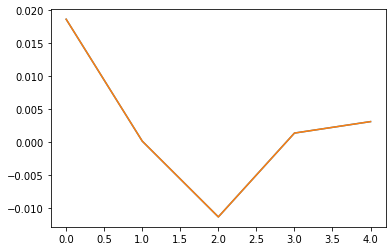

In [133]:
var_id = 0
plt.plot(np.nanmedian(single_test_preds[:, :, var_id], axis = 1))
plt.plot(np.nanmedian(np.nanmedian(multi_test_preds[var_id, :, :, :], axis = 1), axis = 0))